In [1]:
%load_ext autoreload
%autoreload 2

## CSV to midi

### Setup

In [2]:
import pandas as pd
import numpy as np
import pretty_midi
import fluidsynth
from IPython import display
import glob
import collections
import tensorflow as tf
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'fluidsynth'

In [ ]:
filenames = glob.glob('raw_data/mozart_sonatas/mps - K*')
print('Number of files:', len(filenames))
print('first file:', filenames[0])

**create pieces df (each row is one piece)**

In [ ]:
pieces_df = pd.read_csv('raw_data/mozart_sonatas/mps - pieces.csv')
pieces_df.head()

### Normalize pitches to C major / A minor

**create key converter dictionaries**

In [ ]:
all_keys = set([key for key in pieces_df.key.value_counts().index])
all_keys

In [ ]:
# key: # of half steps to add to get to c major / a minor
maj_key_converter_dict = {'a major': 3, 'bb major': 2, 'c major': 0, 'd major': -2, 'eb major': -3, 'f major': -5, 'g major': 5}
min_key_converter_dict = {'a minor': 0, 'c minor': -3, 'f minor': 4}

In [ ]:
def normalize_pitches(x, piece_key_type, piece_key):
    if x > 0:
        if piece_key_type == 'major':
            x += maj_key_converter_dict[piece_key]
        else:
            x += min_key_converter_dict[piece_key]
    return x

### Create duration (in seconds) column

In [ ]:
bpm_beat_types = set([bpm.split('=')[0] for bpm in pieces_df.bpm.value_counts().index])
bpm_beat_types

In [ ]:
# bpm note value: amount to multiply bpm by to convert bpm to quarter notes
bpm_converter_dict = {'2': 2, '2d': 3, '4': 1, '4d': 1.5, '8': 0.5}

In [ ]:
# duration: amount to multiply spb (seconds per beat) by to get duration in seconds
beat_dict = {
    '1': 4, 
    '2': 2, 
    '4': 1, 
    '8': 0.5,
    '16': 0.25,
    '32': 0.125,
    '64': 0.0625
}

In [ ]:
def duration_to_seconds(x, piece_spb):
    if type(x) != 'str':
        x = str(x)
    if x[-2:] == 'dd':
        s = piece_spb * beat_dict[x[:-2]] * 1.75
    elif x[-1] == 'd':
        s = piece_spb * beat_dict[x[:-1]] * 1.5
    else:
        s = piece_spb * beat_dict[x]
    return s

### preprocess all dfs

In [ ]:
def process_df(filename):
    
    # extract the K number
    k_num = filename.split(' - ')[1].split('.csv')[0].strip(' ')
    
    # create df
    df = pd.read_csv(filename)  # make df
    
    # normalize pitch
    df['pitch'] = df.note_name.apply(lambda x: pretty_midi.note_name_to_number(x) if x != 'r' else 0)  
    piece_key = pieces_df[pieces_df['name'] == k_num]['key'].values[0].strip(' ')
    piece_key_type = piece_key.split(' ')[1].strip(' ')
    df['pitch_norm'] = df.pitch.apply(normalize_pitches, args=(piece_key_type, piece_key))
    
    # get duration in seconds
    piece_bpm = pieces_df[pieces_df['name'] == k_num]['bpm'].values[0].split('=')
    piece_bpm_norm = int(bpm_converter_dict[piece_bpm[0]] * int(piece_bpm[1]))
    piece_spb = 60 / piece_bpm_norm
    df['dur(s)'] = df.duration.apply(duration_to_seconds, args=(piece_spb,))
    
    return df

In [ ]:
all_csv_dfs = []
for file in filenames:
    all_csv_dfs.append(process_df(file))

In [ ]:
all_csv_dfs[0].head()

### Create midi file

In [ ]:
def notes_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start)
        end = float(prev_start + note['dur(s)'])
        if note['note_name'] == 'r':
            start += float(note['dur(s)'])
            prev_start = start
        else:
            note = pretty_midi.Note(
                velocity=velocity,
                pitch=int(pretty_midi.note_name_to_number(note['note_name'])),
                start=start,
                end=end
            )
            instrument.notes.append(note)
            prev_start = end
            
    pm.instruments.append(instrument)
    return pm

In [ ]:
instrument_name = 'Acoustic Guitar (nylon)'

all_midis = []
for df in all_csv_dfs:
    pm = notes_to_midi(df, instrument_name)
    all_midis.append(pm)

In [ ]:
stop

### Playback the midi

In [ ]:
_SAMPLING_RATE = 16000

def display_audio(pm: pretty_midi.PrettyMIDI):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    return display.Audio(waveform, rate=_SAMPLING_RATE)

In [ ]:
# instrument_name = 'Electric Piano 1'
instrument_name = 'Acoustic Guitar (nylon)'
out_file = 'example.midi'

example_pm = notes_to_midi(all_dfs[10], instrument_name)

In [ ]:
display_audio(example_pm)

### Create dataframe from midi

In [ ]:
instrument = example_pm.instruments[0]
instrument.notes

In [ ]:
def midi_to_notes(midi: pretty_midi.PrettyMIDI()) -> pd.DataFrame:
#     pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = midi.instruments[0]
    notes = collections.defaultdict(list)
    
    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start-prev_start)
        notes['duration'].append(end - start)
        prev_start = start
        
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
all_midi_dfs = []

for midi in all_midis:
    midi_df = midi_to_notes(midi)
    all_midi_dfs.append(midi_df)

In [ ]:
all_midi_dfs[45].head()

In [ ]:
max_pitch_list = []
min_pitch_list = []
pitch_list = []
for midi in all_midi_dfs:
    max_pitch_list.append(midi.pitch.max())
    min_pitch_list.append(midi.pitch.min())
    for pitch in midi.pitch:
        if pitch not in pitch_list:
            pitch_list.append(pitch)

In [ ]:
pitch_list.sort()
print(f"highest note: {max(max_pitch_list)} ({pretty_midi.note_number_to_name(max(max_pitch_list))})")
print(f"lowest note:, {min(min_pitch_list)} ({pretty_midi.note_number_to_name(min(min_pitch_list))})")
print('number of different notes:', len(pitch_list))

### Create slices

In [ ]:
num_slices_per_midi = 5
slice_length = 4
X = []
y = []

for midi in all_midi_dfs:
    df_len = len(midi)
    last_possible_ind = df_len - (slice_length + 1)
    slice_ind = np.random.choice(last_possible_ind, num_slices_per_midi, replace=False)
    for i in slice_ind:
        X.append(midi.loc[i:i+(slice_length - 1)])
        y.append(midi.loc[i+slice_length])


In [ ]:
X[0].values

In [ ]:
X_seq = []
for slice in X:
    X_seq.append(np.delete(slice.values, [1,2], axis=1))

In [ ]:
X_3d = np.stack(X_seq)

In [ ]:
y_seq = []
for slice in y:
    y_seq.append(np.delete(slice.values, [1,2]))

In [ ]:
y_2d = np.stack(y_seq)

In [ ]:
print(X_3d.shape)
print(y_2d.shape)

### Simple model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def initialize_model():
    model = Sequential()
    model.add(layers.LSTM(units=len(pitch_list), activation='tanh', input_shape=X_3d.shape[1:]))
    model.add(layers.Dense(3, activation='linear'))
    
    model.compile(loss='mse', optimizer='rmsprop')
    
    return model

In [ ]:
model = initialize_model()
model.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=20, restore_best_weights=True)

model = initialize_model()
history = model.fit(X_3d, y_2d, validation_split=0.3, batch_size=16, epochs=300, verbose=1, callbacks=[es])

In [ ]:
plt.plot(history.epoch, history.history['loss'])

In [ ]:
y_pred[0][0]

In [ ]:
X_test = tf.expand_dims(X_3d[0], 0)

y_pred = model.predict(X_test)

y_pred

### Generate Notes

In [ ]:
number_predictions = 20

input_notes = X_3d[0]

generated_notes = []
prev_start = 0
for i in range(number_predictions):
    inputs = tf.expand_dims(input_notes, 0)
    y_pred = model.predict(inputs)
    pitch = int(y_pred[0][0])
    step = y_pred[0][1]
    duration = y_pred[0][2]
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start
    

In [ ]:
generated_notes = pd.DataFrame(generated_notes, columns=all_midi_dfs[0].columns)

In [ ]:
generated_notes

In [ ]:
def midi_df_to_midi(
    notes: pd.DataFrame,
    instrument_name: str,
    velocity: int = 100 # note loudness
) -> pretty_midi.PrettyMIDI:
    
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(
            instrument_name))
    
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(note)
        prev_start = start
        
    pm.instruments.append(instrument)
    return pm

In [ ]:
pm = midi_df_to_midi(generated_notes, instrument_name)
display_audio(pm)

### from RNN tutorial

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true -y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = X_3d.shape[1:]
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(len(pitch_list))(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(len(pitch_list), name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}
                                   

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration': 1.0
    },
    optimizer=optimizer,
)


In [ ]:
es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True)

In [ ]:
%%time
epochs = 10

history = model.fit(
    X_3d,
    epochs=epochs,
    callbacks=[es],
)

### dataframes to tensorflow dataset

In [ ]:
key_order = ['pitch', 'step', 'duration']

midi_arrays = []
for df in all_midi_dfs:
    midi_arrays.append(np.stack([df[key] for key in key_order], axis=1))

In [ ]:
tf_stuff = []
for array in midi_arrays:
    tf_stuff.append(tf.data.Dataset.from_tensor_slices(array))

In [ ]:
list(tf_stuff[0].as_numpy_iterator())

### create slices

# EDA

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import CoolMelodyProject.

# music 21 and muescore

In [4]:
!pip install music21

  Using cached music21-7.1.0.tar.gz (19.2 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 KB 166.7 kB/s eta 0:00:000:00:01m eta 0:00:01
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 KB 164.8 kB/s eta 0:00:001m179.5 kB/s eta 0:00:01
  Created wheel for music21: filename=music21-7.1.0-py3-none-any.whl size=21912583 sha256=93f6d44b6d7ed6732a9d350f57273759889680807fa10340f10337b0a8dca42f
  Stored in directory: /Users/mizukinakano/Library/Caches/pip/wheels/c3/0a/1a/73580f7fc6d1a676a949544d592c0a39546b8ba0477594f2c9
Successfully built music21


In [5]:
from music21 import converter

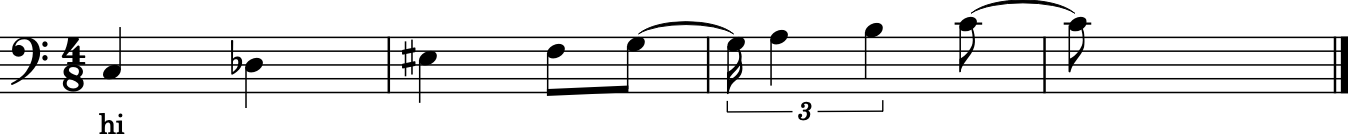

In [9]:
s = converter.parse('tinyNotation: 4/8 C4_hi D-4 E#4 F8 trip{G4 A4 B4} c4')
s.show()

In [7]:
s.show('midi')